In [1]:
import numpy as np
import pandas as pd

import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import TextModality
from cornac.data.text import BaseTokenizer
from cornac.models import CTR
from cornac.data import Reader
from cornac.metrics import MAE,RMSE,MSE,FMeasure,Precision,Recall,NDCG,NCRR,MRR,AUC,MAP

FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.


In [2]:
docs_movielens, item_ids_movielens = cornac.datasets.movielens.load_plot()
feedback_movielens_100K = cornac.datasets.movielens.load_feedback(variant="100K",reader=Reader(item_set=item_ids_movielens))

movielens_item_text_modality = TextModality(
    corpus=docs_movielens,
    ids=item_ids_movielens,
    tokenizer=BaseTokenizer(sep="\t", stop_words="english"),
    max_vocab=8000,
    max_doc_freq=0.5,
)
# Define an evaluation method to split feedback into train and test sets
movieslens100K_ratio_split = RatioSplit(
    data=feedback_movielens_100K,
    test_size=0.2,
    exclude_unknowns=True,
    item_text=movielens_item_text_modality,
    verbose=True,
    seed=123,
    rating_threshold=1,
)

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 943
Number of items = 1518
Number of ratings = 75846
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 941
Number of items = 1279
Number of ratings = 18925
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 943
Total items = 1518


In [3]:
# Instantiate CTR model
ctr = cornac.models.CTR(
    k=50,
    lambda_u=0.01,
    lambda_v=1,
    eta=0.01,
    a=1,
    b=0.01,
    max_iter=50,
    trainable=True,
    verbose=True,
    init_params=None,
    seed=123,
)

# Instantiate MSE for evaluation
metrics = [MAE(), RMSE(), MSE(),FMeasure(k=300),Precision(k=300),
           Recall(k=300), NDCG(k=300), NCRR(k=300),
           MRR(),AUC(), MAP()]

# Put everything together into an experiment and run it
cornac.Experiment(
    eval_method=movieslens100K_ratio_split, models=[ctr], metrics=metrics, user_based=False
).run()


[CTR] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[CTR] Evaluation started!


Rating:   0%|          | 0/18925 [00:00<?, ?it/s]

Ranking:   0%|          | 0/941 [00:00<?, ?it/s]


TEST:
...
    |    MAE |    MSE |   RMSE |    AUC | F1@300 |    MAP |    MRR | NCRR@300 | NDCG@300 | Precision@300 | Recall@300 | Train (s) | Test (s)
--- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + -------- + -------- + ------------- + ---------- + --------- + --------
CTR | 1.3227 | 2.7778 | 1.6667 | 0.8593 | 0.0733 | 0.0859 | 0.3050 |   0.1593 |   0.3334 |        0.0404 |     0.7163 |   32.1183 |   1.3585



In [4]:
from cornac.utils import cache

# Download some information of MovieLens 100K dataset
user_df = pd.read_csv(
  cache("http://files.grouplens.org/datasets/movielens/ml-100k/u.user"),
  sep="|", names=["UserID", "Age", "Gender", "Occupation", "Zip Code"]
).set_index("UserID")

item_df = pd.read_csv(
  cache("http://files.grouplens.org/datasets/movielens/ml-100k/u.item"),
  sep="|", encoding="ISO-8859-1",
  names=["ItemID", "Title", "Release Date", "Video Release Date", "IMDb URL",
         "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
         "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
         "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
).set_index("ItemID").drop(columns=["Video Release Date", "IMDb URL", "unknown"])

# one-hot encoding

In [5]:
item_df.head()

,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [6]:
one_hot = {}
for index, row in item_df.iterrows():
    one_hot[row[0]] = row[2:].values

In [7]:
# import radio metric
import diversity
import diversity_movielens
r = diversity_movielens.MovielensRetrieval(model=ctr, item_df=item_df, UIDX=0, TOPK=10, test_set=movieslens100K_ratio_split.test_set)
d = diversity_movielens.Diversity()
recommendation = d.compute_dict_distr(r.get_recy())
history = d.compute_dict_distr(r.get_history())
# d.compute_kl_divergence(recommendation, history)
i = diversity.IntraDiverse()

In [8]:
print("User 0: top 5 items in the history")
rating_arr = r.convert_idx_id_train_set()[0][0].A.ravel()
top_rated_items = np.argsort(rating_arr)[-5:]
item_df.loc[[int(r.convert_idx_id_train_set()[4][i]) for i in top_rated_items]]

User 0: top 5 items in the history


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
22,Braveheart (1995),16-Feb-1996,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
651,Glory (1989),01-Jan-1989,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
73,Maverick (1994),01-Jan-1994,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
673,Cape Fear (1962),01-Jan-1962,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
692,"American President, The (1995)",01-Jan-1995,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0


In [9]:
# inverse top 10, and compute the recall
recommendations, scores = ctr.rank(0)
item_rank = np.append(np.flip(recommendations[:10]),recommendations[10:])
item_scores = scores[item_rank]
import diversity_mind
rank = diversity_mind.Rank(item_rank, item_scores)
rank.ranking_eval(
            model = ctr,
            metrics = [Recall(k=300)],
            train_set=ctr.train_set,
            test_set=movieslens100K_ratio_split.test_set,
            val_set=None,
            rating_threshold=0.5,
            exclude_unknowns=True,
            verbose=False,
    )

[0.3844045707721076]

# Now select top 5 items
formula: 0.5 * calibration metric + 0.5 * intra_distance

In [10]:
# select 5 from top 10 items
# find all possible combinations
recy = item_df.loc[[int(r.convert_idx_id_train_set()[4][i]) for i in recommendations[:10]]]['Title'].values

import itertools
combinations_idx = []
for c in itertools.combinations(recommendations[:10],5):
    combinations_idx.append(c)

combinations = []
for c in itertools.combinations(recy,5):
    combinations.append(c)

print(len(combinations_idx))
print(len(combinations))

252
252


In [11]:
combinations[0]

('Harold and Maude (1971)',
 'Strictly Ballroom (1992)',
 "It's a Wonderful Life (1946)",
 'Back to the Future (1985)',
 'Vertigo (1958)')

In [12]:
def encode(keys):
    arr = []
    for k in keys:
        arr.append(one_hot.get(k))
    return arr

In [13]:
encode(combinations[0])

[array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object),
 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=object),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object),
 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=object),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0], dtype=object)]

In [14]:
def get_recy(c):
    distr = item_df.loc[[int(r.convert_idx_id_train_set()[4][i]) for i in c]]
    dict = {}
    for index, row in distr.items():
        dict[index] = np.count_nonzero(np.array(row))
    del dict['Title']
    del dict['Release Date']

    return dict

In [15]:
result = []
r_ = diversity_movielens.MovielensRetrieval(model=ctr, item_df=item_df, UIDX=0, TOPK=5, test_set=movieslens100K_ratio_split.test_set)
for c_idx, c in zip(combinations_idx, combinations):
    recommendation = d.compute_dict_distr(get_recy(c_idx))
    history = d.compute_dict_distr(r_.get_history())
    radio = d.compute_kl_divergence(recommendation, history)

    intra = diversity.IntraDiverse()._single_user_distance(encode(c))
    result.append(0.5*radio + 0.5*intra)

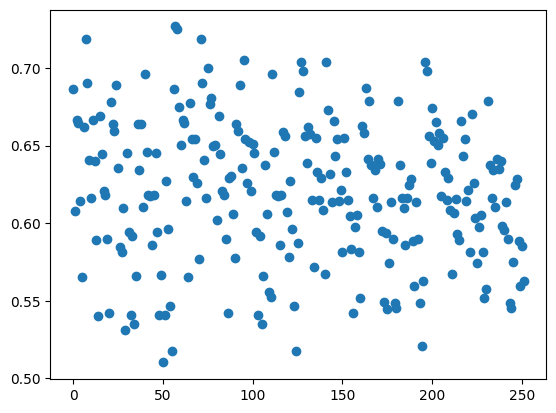

In [16]:
import matplotlib.pyplot as plt

x = np.arange(len(combinations))
plt.plot(x, result,'o')
plt.show()

In [17]:
max_idx = np.argmax(result)
combinations[max_idx]

('Harold and Maude (1971)',
 "It's a Wonderful Life (1946)",
 'Back to the Future (1985)',
 'Vertigo (1958)',
 'Contact (1997)')

In [20]:
result[max_idx]

0.7268079047894633

In [18]:
print("User 0: top 5 items in the recommendations list")
item_df.loc[[int(r.convert_idx_id_train_set()[4][i]) for i in combinations_idx[max_idx]]]

User 0: top 5 items in the recommendations list


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
428,Harold and Maude (1971),01-Jan-1971,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
496,It's a Wonderful Life (1946),01-Jan-1946,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
204,Back to the Future (1985),01-Jan-1985,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
479,Vertigo (1958),01-Jan-1958,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
258,Contact (1997),11-Jul-1997,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [19]:
print("User 0: original top 5 items in the recommendations list")
item_df.loc[[int(r.convert_idx_id_train_set()[4][i]) for i in recommendations[:5]]]

User 0: original top 5 items in the recommendations list


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
428,Harold and Maude (1971),01-Jan-1971,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
709,Strictly Ballroom (1992),01-Jan-1992,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
496,It's a Wonderful Life (1946),01-Jan-1946,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
204,Back to the Future (1985),01-Jan-1985,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
479,Vertigo (1958),01-Jan-1958,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
